# Preserving clustering and correlations: A tutorial

We will use the Macosco cell dataset (Highly Parallel Genome-wide Expression Profiling of Individual Cells Using Nanoliter Droplets, Macosko et al) for demonstrating methods for dimensionality reduction with high global structure perservation.

Lets start by loading the dataset, and a utility function plot_embeddings for visualizing the 2D transformed data, and plotting some metrics.



In [1]:
import umap
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
import requests
import gzip
import pickle
from io import BytesIO
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from zadu import zadu

from pcc import PCC, PCUMAP

def download_and_load_dataset(url):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with gzip.open(BytesIO(response.content), "rb") as f:
        data = pickle.load(f)
    return data


def plot_embeddings(embeddings_2d, X, y, method, downsample_for_metrics=16):
    spec = [{
        "id"    : "tnc"
    },
    {"id": "mrre"},
    {"id": "pr"},
    {"id": "srho"}]
    X = np.float32(X)
    y = list(map(int, y))
    # Visualize the result
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

    local_keys = ['trustworthiness', 'continuity', 'mrre_false', 'mrre_missing']
    global_keys = ['pr', 'srho']

    all_scores = zadu.ZADU(spec, X[::downsample_for_metrics, :]).measure(embeddings_2d[::downsample_for_metrics, :])
    scores = []
    local_scores = []
    global_scores = []
    for s in all_scores:
        for k, v in s.items():
            if k in local_keys:
                local_scores.append(f"{k}: {v:.3f}")
            else:
                global_scores.append(f"{k}: {v:.3f}")

    scores_str = 'Global metrics: ' + ' '.join(global_scores) + '\n' + 'Local metrics: ' + ' '.join(local_scores)

    plt.title(f'{method}\n{scores_str}')
    plt.xlabel(f'{method} 1')
    plt.ylabel(f'{method} 2')

# --- Download Macosko data ---
url_macosko = "http://file.biolab.si/opentsne/benchmark/macosko_2015.pkl.gz"
data_macosko = download_and_load_dataset(url_macosko)

x_macosko = data_macosko["pca_50"].astype("float32")
y_macosko = data_macosko["CellType1"].astype(str)
y_macosko_encoded = LabelEncoder().fit_transform(y_macosko)
X, y = x_macosko, y_macosko_encoded

c:\Users\PahnkeLab\miniconda3\envs\maldi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# UMAP

Lets first run UMAP, a widely used dimensionality reduction method.

As you can see, UMAP is excellent in local structure reconstruction and is able to form the data in clusters, however it has low global structure corerlation metrics with a peasron correlation metric of around 0.59

c:\Users\PahnkeLab\miniconda3\envs\maldi\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


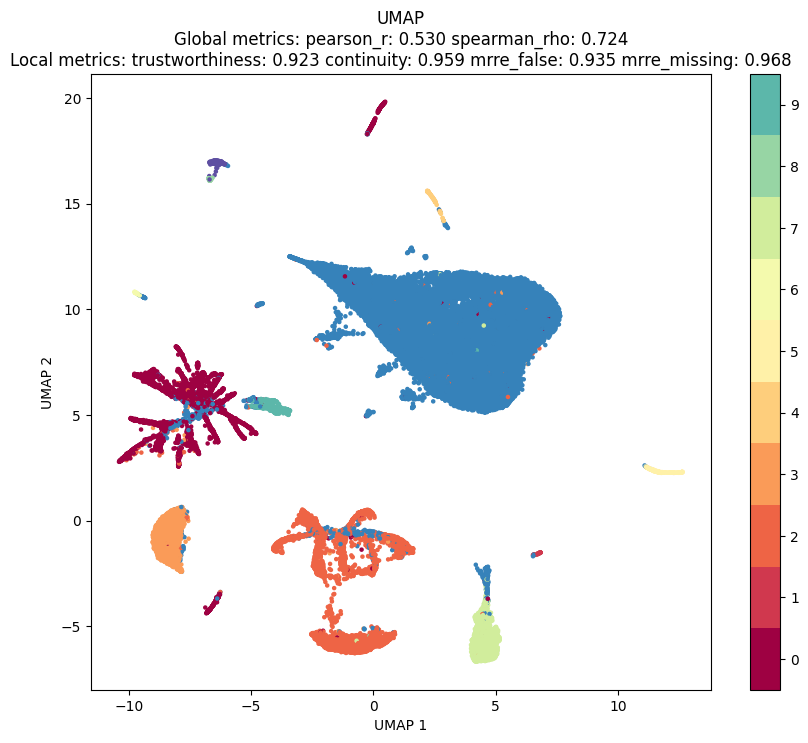

In [2]:
reducer = umap.UMAP(random_state=42, n_components=2)
umap_embedding = reducer.fit_transform(X)
plot_embeddings(umap_embedding, X, y, "UMAP")

#PCC

PCC optimizes for both global and local structure preservation. For local structure preservation, it simply tries to predict which cluster a point belongs to.
For global structure preservation, it maximizes the correlations of distances of points to sampled reference points, in both the high and low (transormed) dimensional data.
We use multiple clustering models and have a multi task objective.

First we create clustering labels to predict, and we pass them to PCC.

The parameters are:
- num_components: We reduce into 2 dimensions.
- num_epochs: We run this for 1000 iterations.
- num_points: We sample 1,000 reference points. More refence will be more computationally expensive, but more accurate.
- pearson/spearman: We can chose if we want to use the pearson or spearman rank corerlation, or both. In most cases, pearson corelation will be faster.
- beta: We weight the global structure preservation loss.
- k_epoch: We run the global loss every second iteration. A higher value here will make it faster, and better in the local structure preservation, on the expense of the global structure preservation.

Initialized embeddings


100%|██████████| 2000/2000 [00:38<00:00, 52.07it/s]


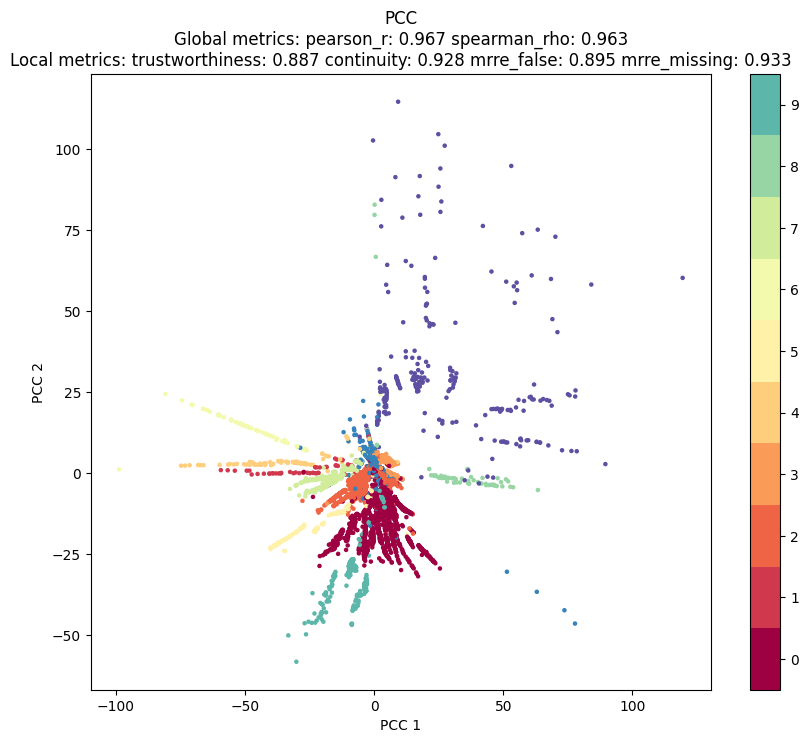

In [4]:
np.random.seed(0)

clusters = []
n_clusters_list = [4, 8, 16, 32, 64]
for n_clusters in n_clusters_list:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    cluster_labels = kmeans.fit_predict(X)
    clusters.append(cluster_labels)

pcc_reducer = PCC(num_components=2, num_epochs=2000, num_points=1000, pearson=True, spearman=False, beta=5, k_epoch=2)
pcc_embedding = pcc_reducer.fit_transform(X, clusters)

plot_embeddings(pcc_embedding, X, y, "PCC")


# PCUMAP: Combining UMAP with the global correlation loss
Finally, we will show we can enjoy the benefits of UMAP, the high local structure preservation, and improve the global structure preservation, by a lot (.59 to 0.9).

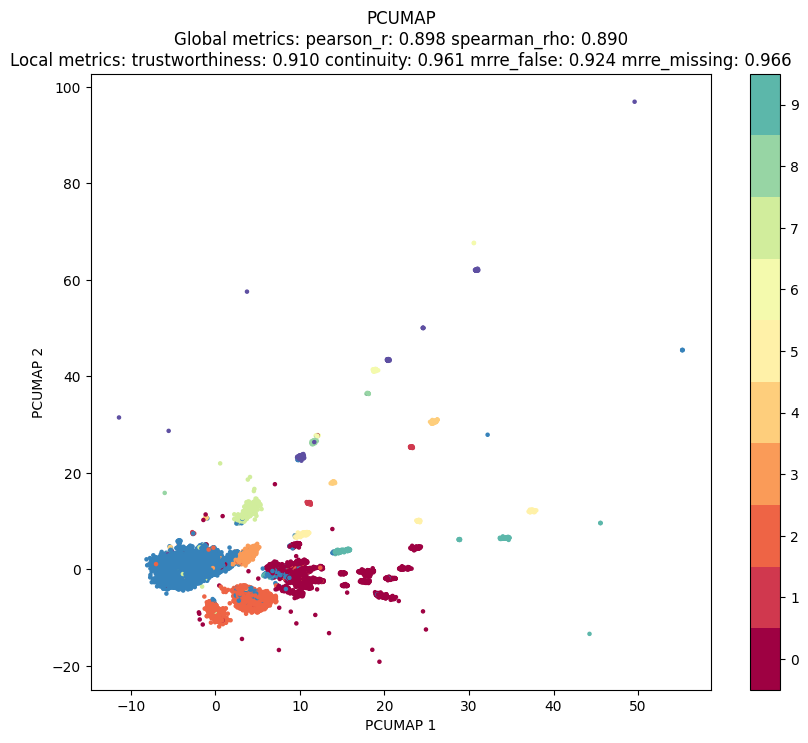

In [7]:
from pcc import PCUMAP
pcumap_reducer = PCUMAP(device='cuda')
pcumap_embedding = pcumap_reducer.fit_transform(X)
plot_embeddings(pcumap_embedding, X, y, "PCUMAP")